In [189]:
#Import potrebnih biblioteka
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score,precision_score,recall_score,f1_score

In [190]:
#Ucitavamo podatke
df = pd.read_csv("spotify.csv", na_values=['-', ' ', ''], encoding='latin1')
display(df.head())
df.info()

,track_name,released_year,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,bpm,mode,energy,instrumentalness,liveness,speechiness
0,Seven (feat. Latto) (Explicit Ver.),2023,553,147.0,141381703,43,263.0,125,Major,83,0,8,4
1,LALA,2023,1474,48.0,133716286,48,126.0,92,Major,74,0,10,4
2,vampire,2023,1397,113.0,140003974,94,207.0,138,Major,53,0,31,6
3,Cruel Summer,2019,7858,NaN,800840817,116,207.0,170,Major,72,0,11,15
4,WHERE SHE GOES,2023,3133,50.0,303236322,84,133.0,144,Minor,80,63,11,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            953 non-null    object 
 1   released_year         953 non-null    int64  
 2   in_spotify_playlists  953 non-null    int64  
 3   in_spotify_charts     951 non-null    float64
 4   streams               953 non-null    int64  
 5   in_apple_playlists    953 non-null    int64  
 6   in_apple_charts       951 non-null    float64
 7   bpm                   953 non-null    int64  
 8   mode                  953 non-null    object 
 9   energy                953 non-null    int64  
 10  instrumentalness      953 non-null    int64  
 11  liveness              953 non-null    int64  
 12  speechiness           953 non-null    int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 96.9+ KB


In [191]:
#Kreiranje izlazne varijable
#Proveravamo da li varijabla streams ima nedostajuće vrednosti jer na osnovu nje kreiramo izlaznu varijablu
print("Broj nedostajućih vrednosti varijable streams:", df['streams'].isna().sum())
#Nema nedostajućih vrednosti
#Računamo treći kvartil
streams_3Q = df['streams'].quantile(0.75)
print(streams_3Q)
#Kreiramo izlaznu varijablu HighStreams na osnovu vrednosti varijable streams
df['HighStreams'] = np.where(df['streams'] > streams_3Q, 'Yes', 'No')
df['HighStreams'] = df['HighStreams'].map({'Yes': 1, 'No': 0})
#Odmah izbacujemo varijablu streams jer smo je koristili za kreiranje izlazne varijable
df.drop(columns='streams', inplace=True)

Broj nedostajućih vrednosti varijable streams: 0
673801126.0


In [192]:
#Zamena nedostajucih vrednosti
#Proveravamo da li varijable imaju nedostajuće vrednosti
print(df.isna().sum())
#Varijable in_spotify_charts i in_apple_charts imaju po 2 nedostajuće vrednosti

track_name              0
released_year           0
in_spotify_playlists    0
in_spotify_charts       2
in_apple_playlists      0
in_apple_charts         2
bpm                     0
mode                    0
energy                  0
instrumentalness        0
liveness                0
speechiness             0
HighStreams             0
dtype: int64


In [193]:
#Proveravamo da li varijable imaju normalnu raspodelu
p_spotify = shapiro(df['in_spotify_charts'].dropna())[1]
p_apple = shapiro(df['in_apple_charts'].dropna())[1]
print("p-vrednost za in_spotify_charts:", p_spotify)
print("p-vrednost za in_apple_charts:", p_apple)
#Obe varijable imaju vrednost p < 0.05 što znači da nemaju normalnu raspodelu i nedostajuce vrednosti zamenićemo medijanom
median_spotify = df['in_spotify_charts'].median()
print("Vrednost medijane spotify:",median_spotify)
median_apple = df['in_apple_charts'].median()
print("Vrednost medijane apple:",median_apple)
df['in_spotify_charts'] = df['in_spotify_charts'].fillna(median_spotify)
df['in_apple_charts'] = df['in_apple_charts'].fillna(median_apple)
print(df.isna().sum())
#Nema vise nedostajucih vrednosti

p-vrednost za in_spotify_charts: 1.4519411043897098e-39
p-vrednost za in_apple_charts: 4.467185022285124e-26
Vrednost medijane spotify: 3.0
Vrednost medijane apple: 38.0
track_name              0
released_year           0
in_spotify_playlists    0
in_spotify_charts       0
in_apple_playlists      0
in_apple_charts         0
bpm                     0
mode                    0
energy                  0
instrumentalness        0
liveness                0
speechiness             0
HighStreams             0
dtype: int64


In [194]:
#Procena znacajnosti atributa za ukljucivanje u model
#Prvo izbacujemo varijablu track_name, jer je očigledno da nema smisla koristiti je za predviđanje
#Svaka pesma ima jedinstveno ime, pa ova varijabla neće uticati na to da li pesma ima veliki broj puštanja
df.drop(columns='track_name', inplace=True)

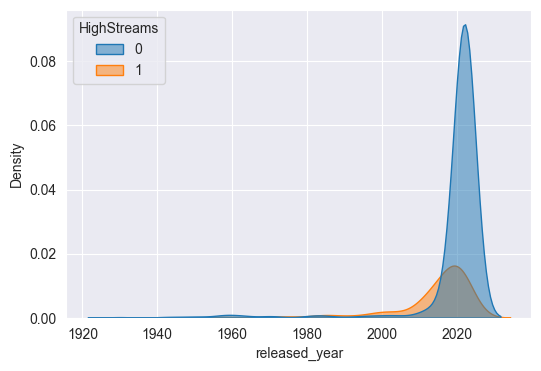

In [195]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='released_year', hue='HighStreams', fill=True, alpha=0.5)
plt.show()
# Na osnovu grafikona vidimo da varijabla released_year ima različitu raspodelu za pesme sa visokim i niskim brojem puštanja, što ukazuje da bi released_year mogla biti značajna

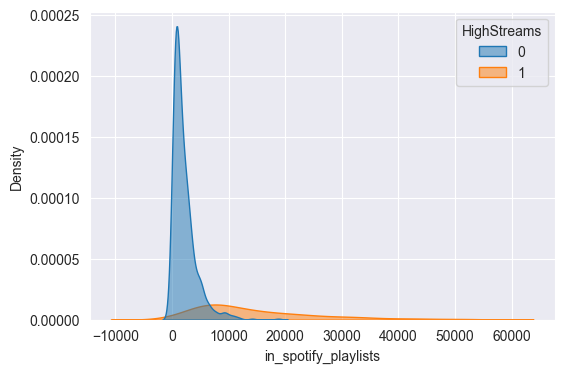

In [196]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='in_spotify_playlists', hue='HighStreams', fill=True, alpha=0.5)
plt.show()
# Na osnovu grafikona vidimo da varijabla in_spotify_playlists ima različitu raspodelu za pesme sa visokim i niskim brojem puštanja. Pesme koje se nalaze na većem broju Spotify plejlista češće imaju veći broj puštanja, pa ova varijabla može biti značajna za predviđanje

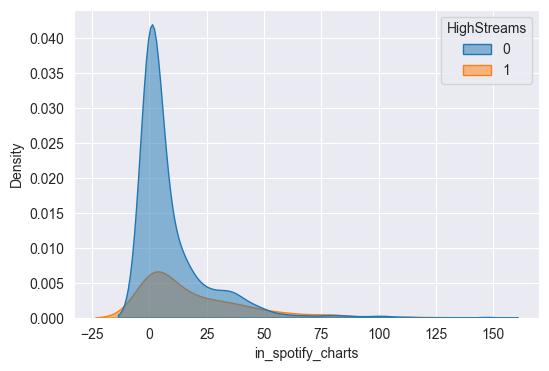

In [197]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='in_spotify_charts', hue='HighStreams', fill=True, alpha=0.5)
plt.show()
# Na osnovu grafikona vidimo da varijabla in_spotify_charts ima različitu raspodelu za pesme sa visokim i niskim brojem puštanja. Pesme koje su bolje rangirane na Spotify listi (manji broj pozicije) češće imaju veći broj puštanja, pa ova varijabla može biti značajna za predviđanje

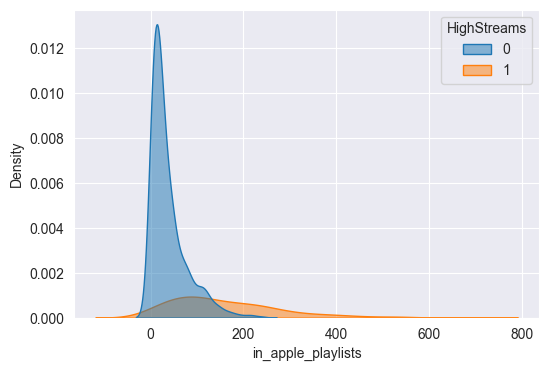

In [198]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='in_apple_playlists', hue='HighStreams', fill=True, alpha=0.5)
plt.show()
# Na osnovu grafikona vidimo da varijabla in_apple_playlists ima različitu raspodelu za pesme sa visokim i niskim brojem puštanja, pa ova varijabla može biti značajna za predviđanje

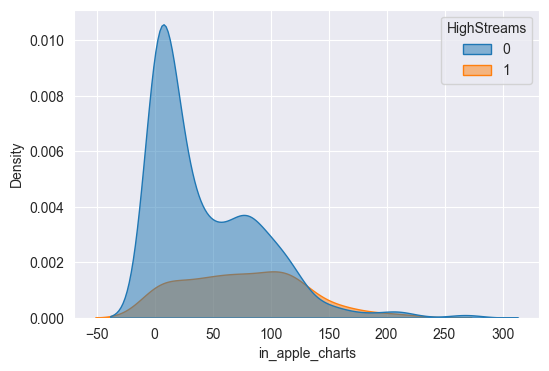

In [199]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='in_apple_charts', hue='HighStreams', fill=True, alpha=0.5)
plt.show()

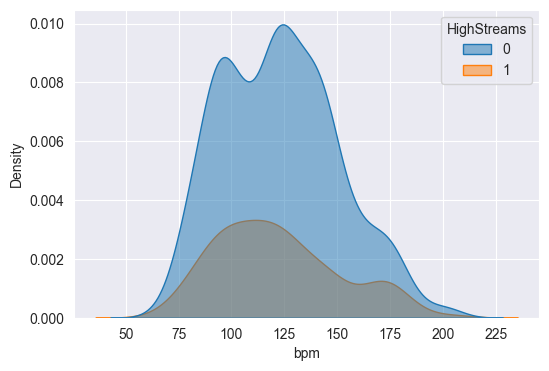

In [200]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='bpm', hue='HighStreams', fill=True, alpha=0.5)
plt.show()
# Na osnovu grafikona vidimo da varijabla bpm ima sličnu raspodelu za pesme sa visokim i niskim brojem puštanja. Zato ovu varijablu možemo izostaviti, izbacujemo je
df.drop(columns='bpm', inplace=True)

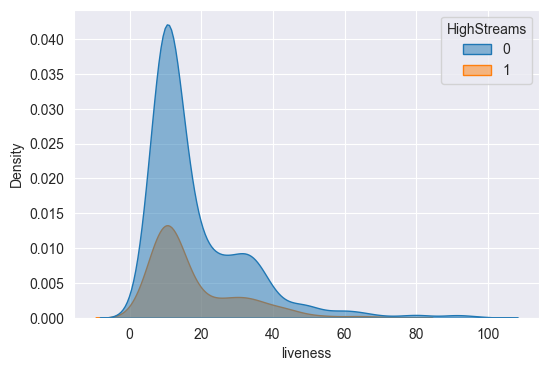

In [201]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='liveness', hue='HighStreams', fill=True, alpha=0.5)
plt.show()
# Na osnovu grafikona vidimo da varijabla liveness ima sličnu raspodelu za pesme sa visokim i niskim brojem puštanja. Zato ovu varijablu možemo izostaviti, izbacujemo je
df.drop(columns='liveness', inplace=True)

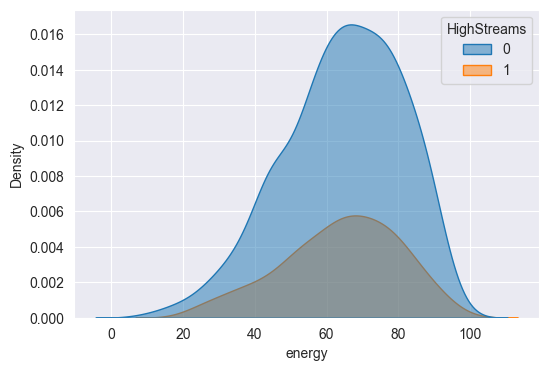

In [202]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='energy', hue='HighStreams', fill=True, alpha=0.5)
plt.show()
# Na osnovu grafikona vidimo da varijabla energy ima sličnu raspodelu za pesme sa visokim i niskim brojem puštanja. Zato ovu varijablu možemo izostaviti, izbacujemo je
df.drop(columns='energy', inplace=True)

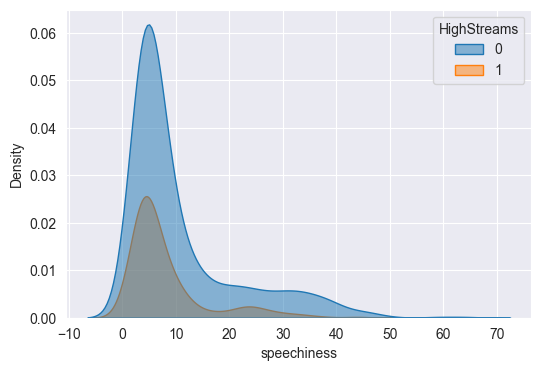

In [203]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='speechiness', hue='HighStreams', fill=True, alpha=0.5)
plt.show()
# Na osnovu grafikona vidimo da varijabla speechiness ima sličnu raspodelu za pesme sa visokim i niskim brojem puštanja. Zato ovu varijablu možemo izostaviti, izbacujemo je
df.drop(columns='speechiness', inplace=True)

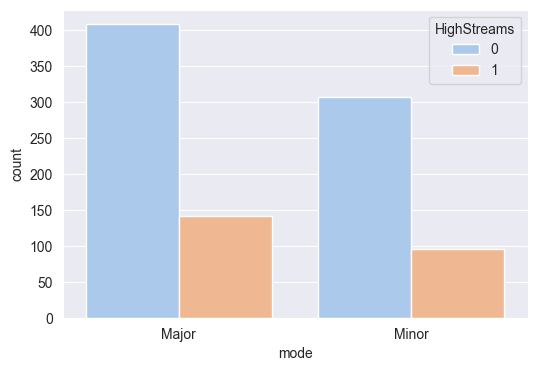

In [204]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='mode', hue='HighStreams', palette='pastel')
plt.show()
# Na osnovu grafikona vidimo da pesme u minor modu imaju malo veću šansu da imaju manji broj puštanja. Iako ne deluje kao toliko jak prediktor kao neke od prethodnih varijabli, može biti značajna pa je ostavljamo

In [205]:
#Skaliranje numerickih varijabli
print(df.describe())
print(df.info())

       released_year  in_spotify_playlists  in_spotify_charts  \
count     953.000000            953.000000         953.000000   
mean     2018.238195           5200.124869          11.853095   
std        11.116218           7897.608990          19.320751   
min      1930.000000             31.000000           0.000000   
25%      2020.000000            875.000000           0.000000   
50%      2022.000000           2224.000000           3.000000   
75%      2022.000000           5542.000000          16.000000   
max      2023.000000          52898.000000         147.000000   

       in_apple_playlists  in_apple_charts  instrumentalness  HighStreams  
count          953.000000       953.000000        953.000000   953.000000  
mean            67.812172        51.665268          1.581322     0.249738  
std             86.441493        50.376630          8.409800     0.433088  
min              0.000000         0.000000          0.000000     0.000000  
25%             13.000000         

In [206]:
numeric_vars = ['released_year', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts']

In [207]:
# Funkcija za izračunavanje broja autlajera
def count_outliers(variable):
    q1 = variable.quantile(0.25)
    q3 = variable.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((variable < lower) | (variable > upper)).sum()
outliers_per_column = df[numeric_vars].apply(count_outliers)
print("Broj autlajera po kolonama:\n", outliers_per_column)
#Sve varijable imaju autlajere, tako da ćemo koristiti standardizaciju


Broj autlajera po kolonama:
 released_year           151
in_spotify_playlists    109
in_spotify_charts        76
in_apple_playlists       78
in_apple_charts          12
dtype: int64


In [208]:
#Proveravamo da li varijable imaju normalnu raspodelu kako bismo odlučili na koji način da izvršimo standardizaciju
shapiro_results = df[numeric_vars].apply(lambda x: shapiro(x)[1])
print("Shapiro-Wilk p-vrednosti:\n", shapiro_results)
#Sve varijable imaju p-vrednosti < 0.05, što znači da nemaju normalnu raspodelu
#Zbog toga cemo ih standardizovati pomocu RobustScaler-a, koji koristi median i IQR (interkvartilni opseg, razlika između 3. i 1. kvartila)

Shapiro-Wilk p-vrednosti:
 released_year           1.210310e-47
in_spotify_playlists    2.585440e-41
in_spotify_charts       1.284461e-39
in_apple_playlists      4.262281e-37
in_apple_charts         4.332586e-26
dtype: float64


In [209]:
#Standardizujemo numericke varijable pomocu RobustScaler-a
robust_scaler = RobustScaler()
df_st = pd.DataFrame() # Kreiramo prazan DataFrame u koji cemo ubaciti sve vrednosti pripremljene za KNN
df_st[numeric_vars] = robust_scaler.fit_transform(df[numeric_vars])

In [210]:
#Transformacija binarnih i kategorijskih varijabli u numericke
print(df.info())
#Jedina varijabla koja nije numericka je mode

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   released_year         953 non-null    int64  
 1   in_spotify_playlists  953 non-null    int64  
 2   in_spotify_charts     953 non-null    float64
 3   in_apple_playlists    953 non-null    int64  
 4   in_apple_charts       953 non-null    float64
 5   mode                  953 non-null    object 
 6   instrumentalness      953 non-null    int64  
 7   HighStreams           953 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 59.7+ KB
None


In [211]:
print(df['mode'].unique())
#Varijabla mode ima samo dve vrednosti ('Major' i 'Minor'), binarna je i možemo je mapirati u brojeve (npr. 0 i 1)
df_st['mode'] = df['mode'].map({'Major': 0, 'Minor': 1})

['Major' 'Minor']


In [212]:
#Dodajemo i izlaznu varijablu HighStreams u standardizovani DataFrame
df_st['HighStreams'] = df['HighStreams']

In [213]:
#Delimo podatke na trening (80%) i test (20%) skup
X = df_st.drop(columns='HighStreams')
y = df_st['HighStreams']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [214]:
#Izracunavanje optimalne vrednosti za parametar k
knn = KNeighborsClassifier()
#Koristimo neparne vrednosti za k (broj suseda) u opsegu od 3 do 25
param_grid = {'n_neighbors': list(range(3, 26, 2))}
#Primenjujemo kros validaciju sa 10 iteracija
cv = GridSearchCV(estimator=knn,
                  param_grid=param_grid,
                  cv=10,
                  scoring='accuracy',
                  verbose = 1,
                  n_jobs = -1)
cv.fit(X_train, y_train)
best_k = cv.best_params_['n_neighbors']
print("Optimalna vrednost za k:", best_k)
#Dobili smo da nam je optimalna vrednost za parametar k=11

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Optimalna vrednost za k: 11


In [215]:
#Kreiranje KNN klasifikatora
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

,n_neighbors,11
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [216]:
y_pred = knn.predict(X_test)

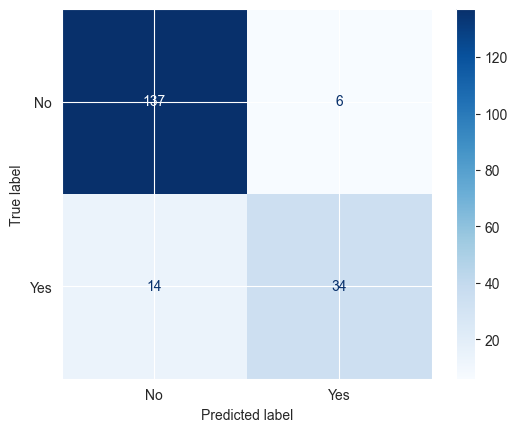

In [217]:
#Kreiranje matrice konfuzije
cm_knn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                              display_labels=['No', 'Yes'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [218]:
#True positive (TP) – za 34 pesama smo predvideli da će imati veliki broj puštanja i one zaista imaju veliki broj puštanja
#True negative (TN) – za 137 pesama smo predvideli da neće imati veliki broj puštanja i one zaista nemaju veliki broj puštanja
#False positive (FP) – za 6 pesama smo predvideli da će imati veliki broj puštanja, a one zapravo nemaju veliki broj puštanja
#False negative (FN) – za 14 pesama smo predvideli da neće imati veliki broj puštanja, a one zapravo imaju veliki broj puštanja
#Na glavnoj dijagonali matrice (34 i 137) nalaze se tačne predikcije, dok se na sporednoj dijagonali (6 i 14) nalaze pogrešne predikcije.

In [219]:
#Evaluacione metrike
def compute_eval_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return {
        'accuracy': accuracy,
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    }

In [220]:
knn_eval = compute_eval_metrics(y_test, y_pred)
print(knn_eval)

{'accuracy': 0.8952879581151832, 'precision': 0.85, 'recall': 0.7083333333333334, 'f1': 0.7727272727272727}


In [221]:
#Tumačenje metrika u kontekstu problema koji se rešava u zadatku:
#Accuracy – za 89.53% pesama smo tačno predvideli da li će imati veliki broj puštanja ili ne
#Precision – od svih pesama za koje smo predvideli da će imati veliki broj puštanja, 85% zaista ima veliki broj puštanja
#Recall – od svih pesama koje zaista imaju veliki broj puštanja, mi smo tačno predvideli 70.83% njih
#F1 score – mera koja balansira preciznost i odziv, i u našem slučaju iznosi 0.77.
#Može se reći da naš model uspešno balansira između sposobnosti da prepozna većinu pesama koje zaista imaju veliki broj puštanja i toga da ne označava previše pesama kao pesme sa velikim brojem puštanja kada one to zapravo nisu.